In [2]:
import os,yaml,argparse
import pytorch_lightning as pl
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from datetime import  datetime
from tbsim.datasets.trajdata_datamodules import PassUnifiedDataModule
from configs.custom_config import dict_to_config,ConfigBase
from tbsim.configs.base import ExperimentConfig
from utils.trainer_utils import prepare_trainer_and_data
from tbsim.utils.trajdata_utils import set_global_trajdata_batch_env, set_global_trajdata_batch_raster_cfg
from tbsim.utils.batch_utils import batch_utils
from tbsim.utils.batch_utils import set_global_batch_type
from tbsim.utils.config_utils import translate_pass_trajdata_cfg
import matplotlib.patches as patches

from tbsim.utils.batch_utils import batch_utils
import matplotlib.pyplot as plt
import numpy as np
from tbsim.utils.scene_edit_utils import get_agt_color
COLORS = {
    "agent_contour": "#247BA0",
    "agent_fill": "#56B1D8",
    "ego_contour": "#911A12",
    "ego_fill": "#FE5F55",
}

import tbsim.utils.geometry_utils as GeoUtils

from l5kit.geometry import transform_points
import tbsim.utils.geometry_utils as GeoUtils

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
registered_name: l5_bc
registered_name: l5_gan
registered_name: l5_bc_gc
registered_name: l5_spatial_planner
registered_name: l5_agent_predicto

In [3]:
parser = argparse.ArgumentParser(description="Training Script")
parser.add_argument("--config", type=str, default="./config.yaml", help="Path to YAML config")
args = parser.parse_args([])
with open(args.config, "r") as f:
    config_dict = yaml.safe_load(f)
train_config = dict_to_config(ConfigBase, config_dict.get("train", {}))
env_config = dict_to_config(ConfigBase, config_dict.get("env", {}))
algo_config = dict_to_config(ConfigBase, config_dict.get("algo", {}))
default_config = ExperimentConfig(
    train_config=train_config,
    env_config=env_config,
    algo_config=algo_config,
    registered_name=config_dict.get("registered_name", "default_experiment"),
)
  
default_config.lock()
cfg = default_config
pl.seed_everything(default_config.seed)
set_global_batch_type("trajdata")
set_global_trajdata_batch_env(default_config.train.trajdata_source_train[0])
set_global_trajdata_batch_raster_cfg(default_config.env.rasterizer)

trajdata_config = translate_pass_trajdata_cfg(cfg)
datamodule = PassUnifiedDataModule(trajdata_config, cfg.train)
datamodule.setup()

Seed set to 1


registered_name: default_experiment
data_cfg.trajdata_predict_types ['vehicle']
{'cache_location': '~/my_custom_cache_location', 'desired_data': ['nusc_trainval-train', 'nusc_trainval-train_val'], 'desired_dt': 0.1, 'future_sec': (5.2, 5.2), 'history_sec': (3.0, 3.0), 'data_dirs': <configs.custom_config.ConfigBase object at 0x72438c97e280>, 'only_types': [<AgentType.VEHICLE: 1>], 'only_predict': [<AgentType.VEHICLE: 1>], 'agent_interaction_distances': defaultdict(<function PassUnifiedDataModule.setup.<locals>.<lambda> at 0x72438c9e0820>, {}), 'incl_raster_map': True, 'raster_map_params': {'px_per_m': 2, 'map_size_px': 224, 'return_rgb': False, 'offset_frac_xy': [-0.5, 0.0], 'no_map_fill_value': -1.0}, 'incl_vector_map': True, 'centric': 'agent', 'scene_description_contains': None, 'standardize_data': True, 'verbose': True, 'max_agent_num': None, 'num_workers': 24, 'rebuild_cache': False, 'rebuild_maps': False, 'extras': {'closest_lane_point': <function get_closest_lane_point_wrapper.<l

/home/visier/ctg_project/trajdata/src/trajdata/dataset_specific/nusc/nusc_dataset.py:62: UserWarning: Beware, nusc_test has no annotations!
  warnings.warn("Beware, nusc_test has no annotations!")
Calculating Agent Data (Serially): 100%|██████████| 700/700 [00:00<00:00, 107660.62it/s]

700 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 700/700 [00:00<00:00, 69116.81it/s]

Loading data for matched scene tags: ['boston-val-nusc_trainval', 'val-singapore-nusc_trainval']



Calculating Agent Data (Serially): 100%|██████████| 150/150 [00:00<00:00, 126614.13it/s]

150 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 150/150 [00:00<00:00, 64680.33it/s]


In [4]:
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

batch =batch_utils().parse_batch(batch)
batch.keys()

dict_keys(['data_idx', 'scene_ts', 'dt', 'agent_name', 'agent_type', 'curr_agent_state', 'agent_hist', 'agent_hist_extent', 'agent_hist_len', 'agent_fut', 'agent_fut_extent', 'agent_fut_len', 'num_neigh', 'neigh_indices', 'neigh_types', 'neigh_hist', 'neigh_hist_extents', 'neigh_hist_len', 'neigh_fut', 'neigh_fut_extents', 'neigh_fut_len', 'robot_fut_len', 'map_names', 'maps', 'maps_resolution', 'vector_maps', 'rasters_from_world_tf', 'agents_from_world_tf', 'scene_ids', 'history_pad_dir', 'extras', 'image', 'drivable_map', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_speeds', 'history_availabilities', 'curr_speed', 'centroid', 'yaw', 'type', 'extent', 'raster_from_agent', 'agent_from_raster', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'all_other_agents_indices', 'all_other_agents_history_positions', 'all_other_agents_history_yaws', 'all_other_agents_history_speeds', 'all_other_agents_history_availabilities'

torch.Size([57, 52])

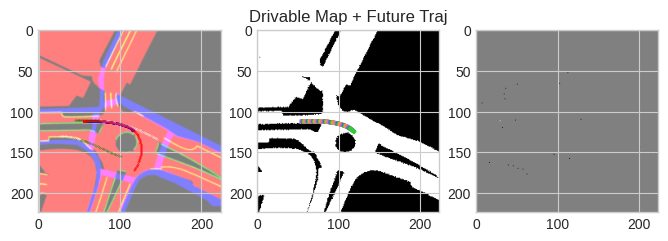

In [9]:
%matplotlib inline
idx=1
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8,8))
image = batch['image'][idx].permute(1,2,0).cpu().numpy()
ax1.imshow(image[...,-3:]*0.5+0.5)
hist_data = image[..., :31]
# hist_sum = hist_data.sum(axis=-1)



drivable_map = batch['drivable_map'][idx].cpu().numpy()
ax2.imshow(drivable_map, cmap="gray")
ax2.set_title("Drivable Map + Future Traj")
# hist_sum = np.sum(image[:,:, :31], axis=-1)

raster_from_agent = batch['raster_from_agent'][idx]
target_position = batch['target_positions'][idx]
target_raster = transform_points(target_position,raster_from_agent)

ax1.scatter(target_raster[:,0], target_raster[:,1], c='b', s=1, label='future')


extent = batch['agent_fut_extent'][idx][:,:2].cpu().numpy()

yaw = batch['target_yaws'][idx].cpu().numpy()
pos = target_position.cpu().numpy()
boxes = GeoUtils.get_box_world_coords_np(pos, yaw, extent)

boxes_raster = transform_points(boxes, raster_from_agent)
boxes_raster = boxes_raster.reshape((-1, 4, 2))
for bi, b in enumerate(boxes_raster):
    cur_fill_color = get_agt_color(bi)
    cur_outline_color = "grey"
    rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
    ax2.add_patch(rect)

hist_position= batch['history_positions'][idx].cpu().numpy()
hist_raster  = transform_points(hist_position,raster_from_agent)
# ax1.scatter(hist_raster[:,0],hist_raster[:,1],c='r',s=0.1)
num_neigh = batch['neigh_indices']

yaw_hist = batch['history_yaws'][idx].cpu().numpy()
pos_hist = batch['agent_hist'][idx][:,:2].cpu().numpy()  #hist_position
extent_hist = batch['agent_hist_extent'][idx][:,:2].cpu().numpy()
boxes_hist = GeoUtils.get_box_world_coords_np(pos_hist,yaw_hist,extent_hist)
boxes_raster_hist = transform_points(boxes_hist,raster_from_agent)
boxes_raster_hist = boxes_raster_hist.reshape((-1,4,2))
# for bi, b in enumerate(boxes_raster_hist):
#     cur_fill_color = get_agt_color(bi+1)
#     cur_outline_color = "grey"
#     rect = patches.Polygon(b, fill=True, color=cur_fill_color, zorder=3)
#     ax1.add_patch(rect)

for i in range(2):
    neighbor_hist = batch['neigh_hist'][idx][i,:,:2]
    neigh_raster = transform_points(neighbor_hist,raster_from_agent)
    ax1.scatter(neigh_raster[:,0], neigh_raster[:,1], c='g', s=0.05, label='future')

for i in range(2):
    neighbor_fut = batch['neigh_fut'][idx][i,:,:2]
    neigh_raster = transform_points(neighbor_fut,raster_from_agent)
    ax1.scatter(neigh_raster[:,0], neigh_raster[:,1], c='w', s=0.05, label='future')

full_traj = batch['extras']['full_fut_traj'][idx][:,:2].cpu().numpy()
full_traj_raster = transform_points(full_traj,raster_from_agent)
ax1.scatter(full_traj_raster[:,0],full_traj_raster[:,1],c='r',s=0.12)

ax3.imshow(drivable_map, cmap="gray")
# for i in range(15):
#     cur_fill_color = get_agt_color(i)
#     closest_lane = batch['extras']['closest_lane_point'][idx][i,:,:2].cpu().numpy()
#     lane_raster = transform_points(closest_lane, raster_from_agent)
#     for il in range(80):
#         ax3.scatter(lane_raster[il,0],lane_raster[il,1],c=cur_fill_color,s=0.1)
all_agents_fut = batch['all_other_agents_future_positions'][idx]
raster_all_fut = transform_points(all_agents_fut,raster_from_agent)
# for i in range(57):

#     ax3.scatter(raster_all_fut[i,:,0],raster_all_fut[i,:,1],c='r',s=0.12)

ax3.imshow(hist_data[...,3], cmap="gray")
batch['all_other_agents_future_availability'][idx].shape

In [ ]:
import  torch
t = torch.randint(0, 20, (4,)).long()
import torch.nn as nn
from tbsim.models.diffuser_helpers import SinusoidalPosEmb

In [3]:
t = torch.randint(0,10, (4,)).long()
t


tensor([1, 8, 6, 5])

In [14]:
time_dim =6
time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.Mish(),
            nn.Linear(time_dim * 4, time_dim),
        )
time = time_mlp(t)
time.shape

torch.Size([4, 6])